In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Activation, Flatten, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from loadFrey import *
from util import importNotebook
from util.dataProcess import *
from util.util import *

Using TensorFlow backend.


importing Jupyter notebook from ../util/dataProcess.ipynb


## Declare the parameters

In [2]:
numEpochs = 100
sizeBatch = 32
sizeKernel = 3
layer_filters = [8, 64]
layerDense = [512, 128, 32, 8]
stdEps = 1.0 
ratRecon = 0.9999
factNoise = 0
nameOptim = 'adam'
patience = 3
pathSave = '../model/temp/'

## Load the datasets

In [3]:
data = load_frey_face_images('frey_rawface.mat')
xTrain, xTest, __ = splitData(data, ratio=[0.8, 0.2])
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = [*xTrain.shape[1:], 1]  # adapt 28*20 as 28*20*1

xTrain = np.reshape(xTrain, [-1, *dimInput])
xTest = np.reshape(xTest, [-1, *dimInput])
print(xTrain.shape)
print(xTest.shape)


(1572, 28, 20, 1)
(393, 28, 20, 1)


## Construct the encoder and decoder

In [4]:
dimEncode = layerDense[-1]
inputs = Input(shape=(dimInput))  # adapt this if using `channels_first` image data format
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=sizeKernel,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
for numFilt in layerDense[:-1]:
    x = Dense(numFilt, activation='relu')(x)
zMean = Dense(dimEncode)(x)
zSigmaLog = Dense(dimEncode)(x) # log for linear dense

def sampling(args):
    zMean, zSigmaLog = args
    epsilon = K.random_normal(shape=(K.shape(zMean)[0], dimEncode),
                              mean=0., stddev=stdEps)
    return zMean + K.exp(zSigmaLog) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
z = Lambda(sampling)([zMean, zSigmaLog])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

# Build the Decoder Model
inputLatent = Input(shape=(dimEncode,), name='decoder_input')
x = inputLatent
for numFilt in layerDense[-2::-1]:
    x = Dense(numFilt, activation='relu')(x)
x = Dense(shape[1] * shape[2] * shape[3])(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=sizeKernel,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=sizeKernel,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(inputLatent, outputs, name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 10, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 5, 64)     4672        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2240)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

## Construct the autoencoder

In [5]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 20, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 8)                 1222464   
_________________________________________________________________
decoder (Model)              (None, 28, 20, 1)         1261297   
Total params: 2,483,761
Trainable params: 2,483,761
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [17]:
def lossVAE(zMean, zSigmaLog):
    def loss(tensorInput, tensorDecode):
        lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
        lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#         lossKL = - 0.5 * K.mean(1 + zSigmaLog - K.square(zMean) - K.exp(zSigmaLog), axis=-1)
        return ratRecon * lossRecon + (1 - ratRecon) * lossKL
    return loss

autoencoder.compile(optimizer=nameOptim, loss=lossVAE(zMean, zSigmaLog))

# callback setting
es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
chkpt = pathSave + 'Conv_AutoEncoder_Frey.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# Train the autoencoder
tic = time()
history = autoencoder.fit(xTrain, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                callbacks=[es_cb, cp_cb],
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 1572 samples, validate on 393 samples
Epoch 1/100
1572/1572 [==============================] - 2s 1ms/step - loss: 0.1612 - val_loss: 0.0384

Epoch 00001: val_loss improved from inf to 0.03842, saving model to ../model/temp/Conv_AutoEncoder_Frey.01-0.16-0.04.hdf5
Epoch 2/100
1572/1572 [==============================] - 0s 311us/step - loss: 0.0382 - val_loss: 0.0382

Epoch 00002: val_loss improved from 0.03842 to 0.03822, saving model to ../model/temp/Conv_AutoEncoder_Frey.02-0.04-0.04.hdf5
Epoch 3/100
1572/1572 [==============================] - 0s 298us/step - loss: 0.0380 - val_loss: 0.0374

Epoch 00003: val_loss improved from 0.03822 to 0.03739, saving model to ../model/temp/Conv_AutoEncoder_Frey.03-0.04-0.04.hdf5
Epoch 4/100
1572/1572 [==============================] - 1s 319us/step - loss: 0.0270 - val_loss: 0.0197

Epoch 00004: val_loss improved from 0.03739 to 0.01966, saving model to ../model/temp/Conv_AutoEncoder_Frey.04-0.03-0.02.hdf5
Epoch 5/100
1572/1572 [========

## Show the historical training progress 

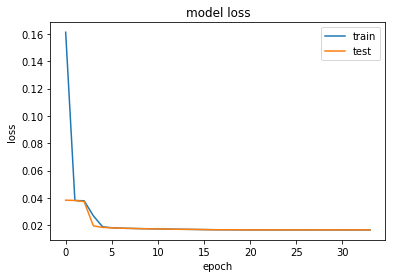

In [18]:
# print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [19]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

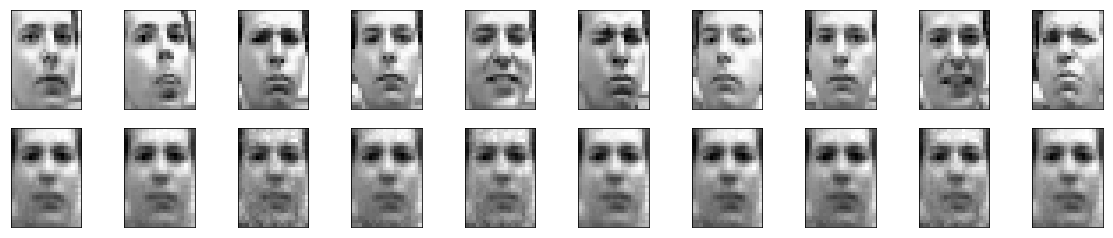

0.00045982847


In [20]:
plotCompDecode(xTest, decodeTest, sizeDigit=[28, 20])
err = compReconst(xTest, decodeTest, method='rmse')
print(err)

## Plot the scatter of the encoding space

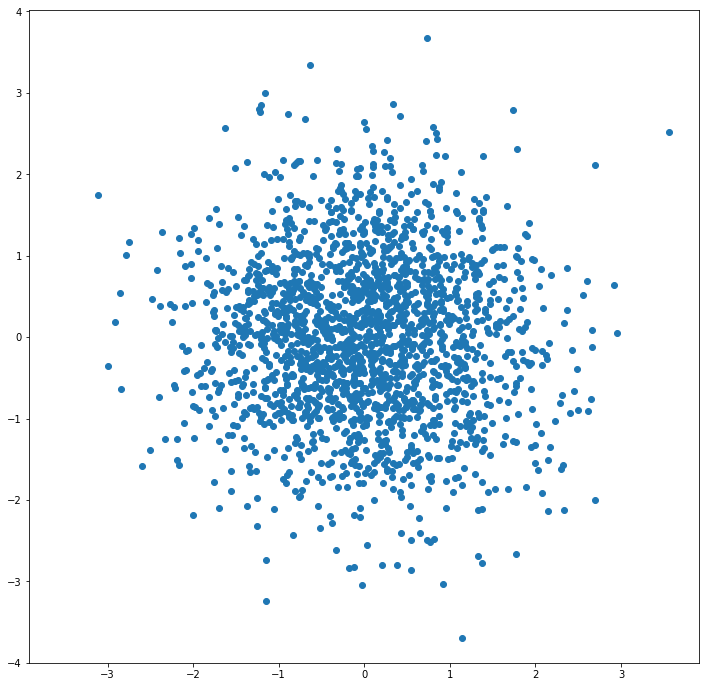

In [12]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, y=None, xlim=xlim, ylim=ylim, numShow=10000)
# scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

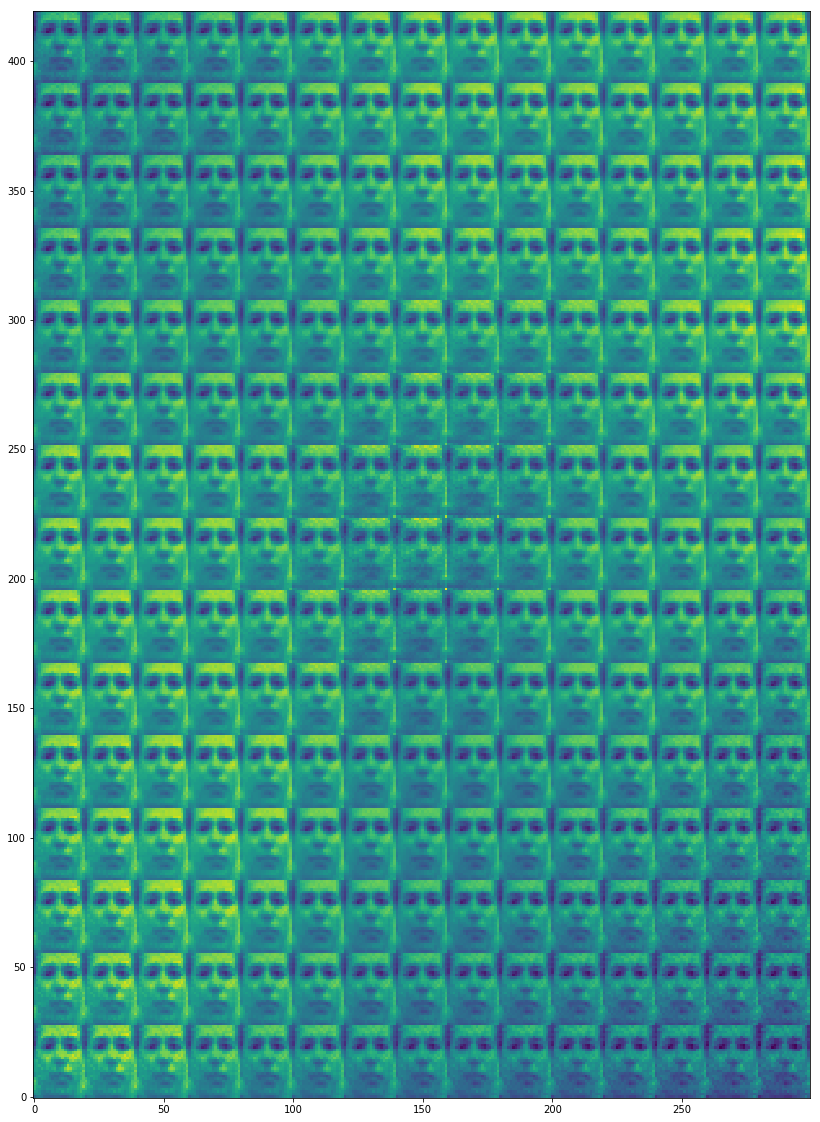

In [13]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, sizeDigit=[28, 20], xlim=xlim, ylim=ylim)

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

In [ ]:
(xTrain, _), (xTest, yTest) = mnist.load_data()